In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display, Markdown
from keras.callbacks import TensorBoard

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


In [2]:
features = pd.read_csv('new_data/features.txt', header=None, names = ['Feature'])
names = list(features.Feature)
names = [x.strip(" ") for x in names]

In [3]:
activity = {'0':'WALKING','1':'WALKING_UPSTAIRS','2':'WALKING_DOWNSTAIRS','3':'SITTING','4':'STANDING',
            '5':'LAYING','6':'STAND_TO_SIT','7':'SIT_TO_STAND','8':'SIT_TO_LIE','9':'LIE_TO_SIT',
            '10':'STAND_TO_LIE','11':'LIE_TO_STAND'}

order = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING',
         'LAYING','STAND_TO_SIT','SIT_TO_STAND','SIT_TO_LIE','LIE_TO_SIT',
         'STAND_TO_LIE','LIE_TO_STAND']


In [4]:
X_train = pd.read_csv('new_data/train/X_train.txt', delim_whitespace=True, header=None, names=names)
y_train = pd.read_csv('new_data/train/y_train.txt', delim_whitespace=True, header=None, names=['activity'])
y_train.activity = y_train.activity - 1

In [5]:
X_test = pd.read_csv('new_data/test/X_test.txt', delim_whitespace=True, header=None, names=names)
y_test = pd.read_csv('new_data/test/y_test.txt', delim_whitespace=True, header=None, names=['activity'])
y_test.activity = y_test.activity - 1

In [6]:
names_EDA = list(names)
names_EDA.extend(['activity'])
EDA_train = np.hstack((X_train,y_train))
EDA_test = np.hstack((X_test,y_test))
EDA = np.vstack((EDA_train,EDA_test))
EDA = pd.DataFrame(EDA,columns=names_EDA)
EDA['activity_name'] = EDA['activity'].apply(lambda x: activity[str(int(x))])

In [7]:
EDA.head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,activity,activity_name
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,4.0,STANDING
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,4.0,STANDING
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,4.0,STANDING
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,4.0,STANDING
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,4.0,STANDING


In [9]:
X_PCA = pd.DataFrame(EDA,columns=names_EDA)
X_PCA.pop('activity')
#PCA
pca = PCA(n_components=40)
pca.fit(X_PCA)
#pca.explained_variance_ratio_
#pca.singular_values_
X_pca = pca.fit_transform(X_PCA)

In [10]:
X_train_pca = X_pca[0:7767]
X_test_pca = X_pca[7767:]

In [11]:
def scree_plot(pca):
    vals = pca.explained_variance_ratio_*100
    plt.figure(figsize=(10, 6), dpi=250)
    cum_var = np.cumsum(vals)
    ax = plt.subplot(111)

    ax.plot(range(len(vals) + 1), np.insert(cum_var, 0, 0), color = 'r', marker = 'o')
    ax.bar(range(len(vals)), vals, alpha = 0.8)
    
    ax.axhline(90, color = 'g', linestyle = "--")
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)

    plt.title("Scree Plot", fontsize=16)
    plt.savefig('images/PCA_40.png')

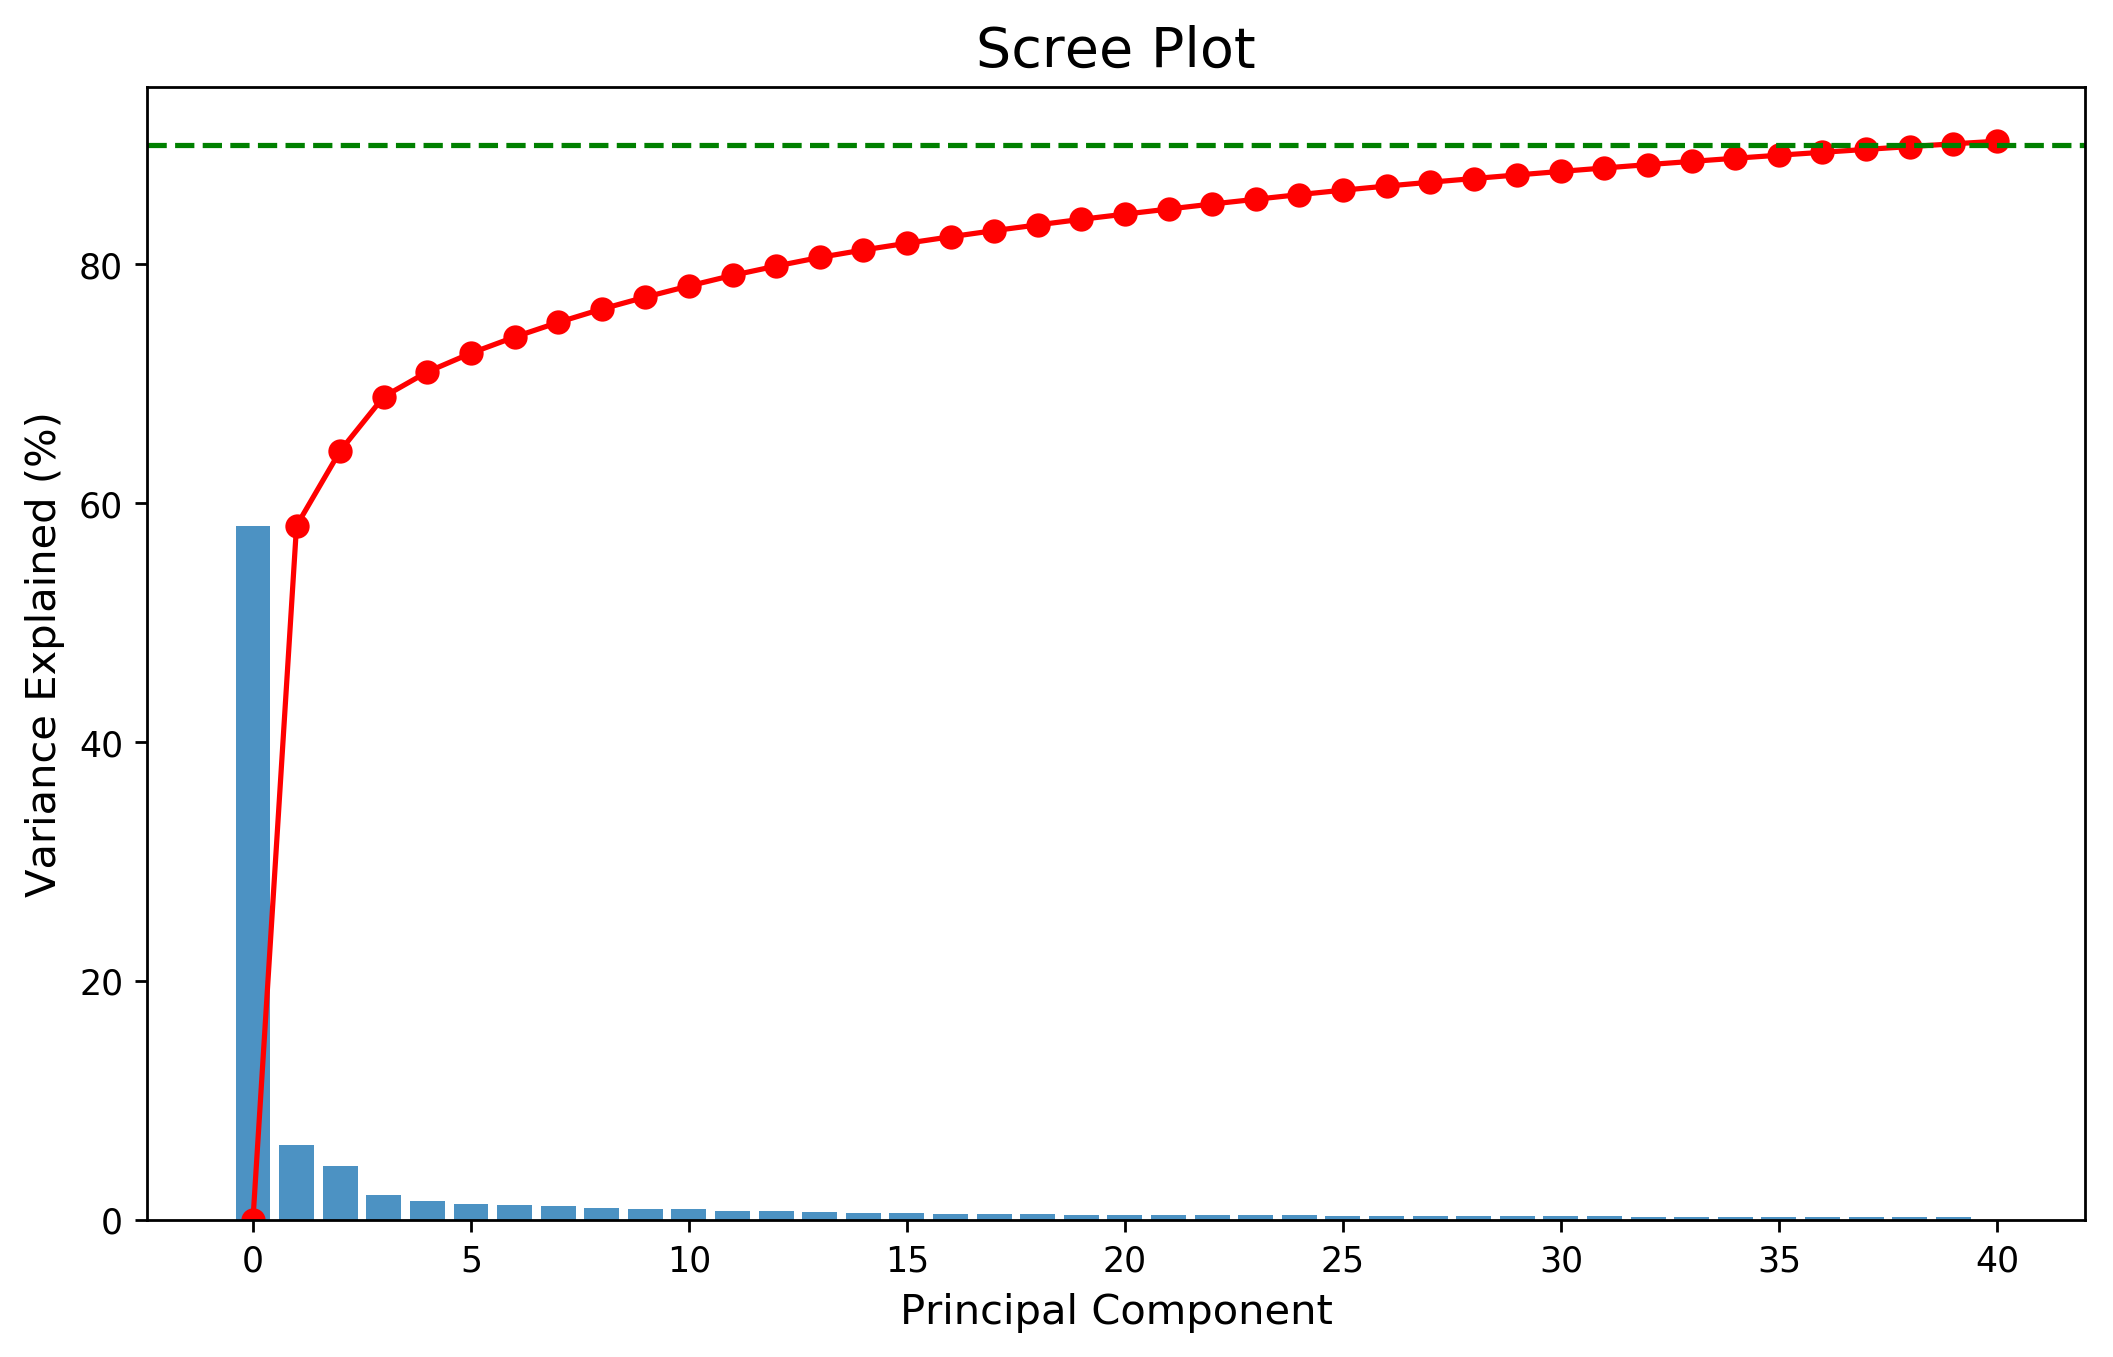

In [12]:
scree_plot(pca)

In [12]:
from IPython.display import display, Markdown
texto  = "| Nº Component |     %    |\n"
texto += "|--------------|----------|\n"
var_acum = 0
for i in range(pca.n_components_):
    var_acum += pca.explained_variance_ratio_[i]
    line = "| {0} |  {1:0.2%} |".format(int(i+1),var_acum)
    texto += line + "\n"
display(Markdown("### PCA variance ratio"))
display(Markdown(texto))

### PCA variance ratio

| Nº Component |     %    |
|--------------|----------|
| 1 |  58.11% |
| 2 |  64.37% |
| 3 |  68.91% |
| 4 |  70.99% |
| 5 |  72.55% |
| 6 |  73.90% |
| 7 |  75.13% |
| 8 |  76.25% |
| 9 |  77.25% |
| 10 |  78.18% |
| 11 |  79.07% |
| 12 |  79.85% |
| 13 |  80.57% |
| 14 |  81.19% |
| 15 |  81.76% |
| 16 |  82.30% |
| 17 |  82.81% |
| 18 |  83.29% |
| 19 |  83.76% |
| 20 |  84.19% |
| 21 |  84.62% |
| 22 |  85.04% |
| 23 |  85.44% |
| 24 |  85.83% |
| 25 |  86.20% |
| 26 |  86.54% |
| 27 |  86.86% |
| 28 |  87.17% |
| 29 |  87.48% |
| 30 |  87.77% |
| 31 |  88.06% |
| 32 |  88.34% |
| 33 |  88.61% |
| 34 |  88.87% |
| 35 |  89.13% |
| 36 |  89.37% |
| 37 |  89.61% |
| 38 |  89.85% |
| 39 |  90.08% |
| 40 |  90.30% |


In [13]:
def compare_predict(y_test,y_hat):
    y_test1 = np.array(y_test)
    compare = np.hstack((y_test1,y_hat.reshape(-1,1)))
    compare = pd.DataFrame(compare,columns=['Real','Predict'])
    temp = pd.DataFrame(pd.pivot_table(compare, values='Predict', index='Real', 
                                    columns='Predict', aggfunc=len))
    temp = pd.DataFrame(np.array(temp.to_records()))
    temp.rename(columns=activity, inplace=True)
    temp['Real'] = temp['Real'].apply(lambda x: activity[str(x)])
    compare_predict = temp
    return compare_predict

# Decision Tree

In [14]:
pipeline_dt = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    ('decisionTree', DecisionTreeClassifier()),
    ])

param_grid = {'decisionTree__min_samples_split':[2,5],
             'decisionTree__presort':[True, False],
             'decisionTree__splitter':['best','random'],
             'decisionTree__max_depth':[None,3,5,10],
             'decisionTree__min_samples_leaf':[1,2,3],
             'decisionTree__max_leaf_nodes':[None,6,10]}

dt = GridSearchCV(pipeline_dt, param_grid=param_grid)

dt.fit(X_train_pca,y_train)
y_hat_pdt = dt.predict(X_test_pca)
print ('Accuracy Score: {0:0.2%}'.format(accuracy_score(y_test,y_hat_pdt)))

Accuracy Score: 80.39%


In [15]:
compare_predict(y_test,y_hat_pdt)

,Real,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,LIE_TO_SIT,STAND_TO_LIE,LIE_TO_STAND
0,WALKING,454.0,25.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WALKING_UPSTAIRS,61.0,356.0,37.0,NaN,NaN,NaN,15.0,NaN,2.0,NaN,NaN,NaN
2,WALKING_DOWNSTAIRS,52.0,52.0,316.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SITTING,NaN,NaN,NaN,376.0,130.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
4,STANDING,NaN,NaN,NaN,122.0,434.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LAYING,NaN,NaN,NaN,11.0,1.0,529.0,1.0,NaN,NaN,3.0,NaN,NaN
6,STAND_TO_SIT,2.0,NaN,NaN,1.0,5.0,NaN,9.0,4.0,1.0,NaN,1.0,NaN
7,SIT_TO_STAND,NaN,NaN,NaN,NaN,1.0,NaN,5.0,2.0,2.0,NaN,NaN,NaN
8,SIT_TO_LIE,NaN,1.0,1.0,1.0,NaN,1.0,3.0,1.0,18.0,NaN,6.0,NaN
9,LIE_TO_SIT,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1.0,14.0,2.0,5.0


# Bagging

In [16]:
pipeline_bag = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    ('bagging', BaggingClassifier()),
    ])

param_grid = {}

bag = GridSearchCV(pipeline_bag, param_grid=param_grid)

bag.fit(X_train_pca,y_train)
y_hat_pbag = bag.predict(X_test_pca)
print ('Accuracy Score: {0:0.2%}'.format(accuracy_score(y_test,y_hat_pbag)))

Accuracy Score: 85.36%


In [17]:
compare_predict(y_test,y_hat_pbag)

,Real,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,LIE_TO_SIT,STAND_TO_LIE,LIE_TO_STAND
0,WALKING,466.0,10.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WALKING_UPSTAIRS,41.0,396.0,29.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2,WALKING_DOWNSTAIRS,49.0,38.0,333.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SITTING,NaN,1.0,NaN,403.0,104.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,STANDING,NaN,NaN,NaN,79.0,476.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
5,LAYING,NaN,NaN,NaN,7.0,NaN,537.0,1.0,NaN,NaN,NaN,NaN,NaN
6,STAND_TO_SIT,2.0,1.0,NaN,4.0,1.0,NaN,13.0,NaN,NaN,NaN,2.0,NaN
7,SIT_TO_STAND,NaN,NaN,NaN,2.0,NaN,NaN,6.0,1.0,1.0,NaN,NaN,NaN
8,SIT_TO_LIE,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,7.0,NaN
9,LIE_TO_SIT,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,15.0,2.0,6.0


# RandomForest

In [18]:
pipeline_rf = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    ('randomforest', RandomForestClassifier()),
    ])

param_grid = {'randomforest__n_estimators':[10,30,50],
              'randomforest__min_samples_split':[2,5,10]}

rf = GridSearchCV(pipeline_rf, param_grid=param_grid)

rf.fit(X_train_pca,y_train)
y_hat_prf = rf.predict(X_test_pca)
print ('Accuracy Score: {0:0.2%}'.format(accuracy_score(y_test,y_hat_prf)))

Accuracy Score: 88.71%


In [19]:
compare_predict(y_test,y_hat_prf)

,Real,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,LIE_TO_SIT,STAND_TO_LIE,LIE_TO_STAND
0,WALKING,475.0,1.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WALKING_UPSTAIRS,27.0,434.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WALKING_DOWNSTAIRS,24.0,48.0,348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SITTING,NaN,2.0,NaN,397.0,109.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,STANDING,NaN,NaN,NaN,45.0,511.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LAYING,NaN,NaN,NaN,2.0,NaN,543.0,NaN,NaN,NaN,NaN,NaN,NaN
6,STAND_TO_SIT,NaN,6.0,NaN,3.0,1.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN
7,SIT_TO_STAND,NaN,1.0,NaN,1.0,NaN,NaN,5.0,3.0,NaN,NaN,NaN,NaN
8,SIT_TO_LIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,8.0,NaN
9,LIE_TO_SIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,17.0,NaN,7.0


# KNeighbors

In [20]:
pipeline_kn = Pipeline([
    ('imputer', Imputer(strategy='median')),
    #('std_scaler', StandardScaler()),
    ('kneighbors', KNeighborsClassifier()),
    ])

param_grid = {'kneighbors__n_neighbors':[5,10,30],
              'kneighbors__weights':['uniform','distance']}

kn = GridSearchCV(pipeline_kn, param_grid=param_grid)

kn.fit(X_train_pca,y_train)
y_hat_pkn = kn.predict(X_test_pca)
print ('Accuracy Score: {0:0.2%}'.format(accuracy_score(y_test,y_hat_pkn)))

Accuracy Score: 87.44%


In [21]:
compare_predict(y_test,y_hat_pkn)

,Real,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,LIE_TO_SIT,STAND_TO_LIE,LIE_TO_STAND
0,WALKING,482.0,3.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WALKING_UPSTAIRS,46.0,408.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WALKING_DOWNSTAIRS,43.0,55.0,322.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SITTING,NaN,4.0,NaN,398.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,STANDING,NaN,1.0,NaN,51.0,504.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LAYING,NaN,1.0,NaN,2.0,NaN,542.0,NaN,NaN,NaN,NaN,NaN,NaN
6,STAND_TO_SIT,1.0,3.0,NaN,NaN,NaN,NaN,17.0,NaN,2.0,NaN,NaN,NaN
7,SIT_TO_STAND,NaN,NaN,NaN,NaN,NaN,NaN,3.0,7.0,NaN,NaN,NaN,NaN
8,SIT_TO_LIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,NaN,4.0,NaN
9,LIE_TO_SIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,19.0,NaN,5.0


# AdaBoost

In [22]:
pipeline_ada = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    ('adaboost', AdaBoostClassifier()),
    ])

param_grid = {'adaboost__learning_rate':[0.3, 0.5],
              'adaboost__n_estimators':[700, 900]}

ada = GridSearchCV(pipeline_ada, param_grid=param_grid)

ada.fit(X_train_pca,y_train)
y_hat_pada = ada.predict(X_test_pca)
print ('Accuracy Score: {0:0.2%}'.format(accuracy_score(y_test,y_hat_pada)))

Accuracy Score: 67.49%


In [23]:
compare_predict(y_test,y_hat_pada)

,Real,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,LIE_TO_SIT,STAND_TO_LIE,LIE_TO_STAND
0,WALKING,279.0,179.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WALKING_UPSTAIRS,16.0,375.0,57.0,NaN,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN
2,WALKING_DOWNSTAIRS,35.0,249.0,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SITTING,NaN,1.0,NaN,380.0,124.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
4,STANDING,3.0,5.0,NaN,207.0,339.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN
5,LAYING,1.0,NaN,NaN,2.0,NaN,540.0,NaN,NaN,1.0,NaN,NaN,1.0
6,STAND_TO_SIT,NaN,1.0,NaN,1.0,NaN,NaN,18.0,NaN,NaN,NaN,3.0,NaN
7,SIT_TO_STAND,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4.0,NaN,NaN,NaN,NaN
8,SIT_TO_LIE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,8.0,NaN
9,LIE_TO_SIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,16.0,1.0,6.0


# SVC

In [24]:
pipeline_svc = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    ('svc', SVC()),
    ])

param_grid = {'svc__C':[0.1,1,10],
              'svc__kernel':['rbf','linear', 'poly', 'sigmoid']}

svc = GridSearchCV(pipeline_svc, param_grid=param_grid)
svc.fit(X_train_pca,y_train)
y_hat_psvc = svc.predict(X_test_pca)
print ('Accuracy Score: {0:0.2%}'.format(accuracy_score(y_test,y_hat_psvc)))

Accuracy Score: 91.27%


In [25]:
compare_predict(y_test,y_hat_psvc)

,Real,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,LIE_TO_SIT,STAND_TO_LIE,LIE_TO_STAND
0,WALKING,480.0,12.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WALKING_UPSTAIRS,43.0,415.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WALKING_DOWNSTAIRS,7.0,47.0,366.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SITTING,NaN,NaN,NaN,447.0,59.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,STANDING,NaN,NaN,1.0,30.0,525.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LAYING,NaN,NaN,NaN,NaN,NaN,545.0,NaN,NaN,NaN,NaN,NaN,NaN
6,STAND_TO_SIT,1.0,2.0,1.0,2.0,1.0,NaN,14.0,NaN,1.0,NaN,1.0,NaN
7,SIT_TO_STAND,NaN,NaN,NaN,NaN,NaN,1.0,NaN,9.0,NaN,NaN,NaN,NaN
8,SIT_TO_LIE,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,22.0,NaN,8.0,1.0
9,LIE_TO_SIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,17.0,NaN,7.0


# Gradient Boosting

In [26]:
pipeline_gb = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    ('gradientboosting', GradientBoostingClassifier()),
    ])


param_grid = {'gradientboosting__n_estimators':[100,300],
              'gradientboosting__learning_rate':[0.1,0.5,1]}

gb = GridSearchCV(pipeline_gb, param_grid=param_grid)
gb.fit(X_train_pca,y_train)
y_hat_pgb = gb.predict(X_test_pca)
print ('Accuracy Score: {0:0.2%}'.format(accuracy_score(y_test,y_hat_pgb)))

Accuracy Score: 89.97%


In [27]:
compare_predict(y_test,y_hat_pgb)

,Real,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,LIE_TO_SIT,STAND_TO_LIE,LIE_TO_STAND
0,WALKING,489.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WALKING_UPSTAIRS,23.0,431.0,16.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,WALKING_DOWNSTAIRS,24.0,53.0,343.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SITTING,NaN,1.0,NaN,444.0,61.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
4,STANDING,NaN,NaN,NaN,37.0,519.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LAYING,NaN,NaN,NaN,4.0,1.0,538.0,NaN,2.0,NaN,NaN,NaN,NaN
6,STAND_TO_SIT,NaN,8.0,NaN,2.0,3.0,NaN,7.0,2.0,1.0,NaN,NaN,NaN
7,SIT_TO_STAND,NaN,1.0,NaN,NaN,NaN,NaN,2.0,7.0,NaN,NaN,NaN,NaN
8,SIT_TO_LIE,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,2.0,12.0,NaN
9,LIE_TO_SIT,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,1.0,9.0


# Neural Network

In [28]:

# from __future__ import division
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
import theano


theano.config.floatX = 'float32'

def define_nn_mlp_model(X_train, y_train_ohe):
    ''' defines multi-layer-perceptron neural network '''
    model = Sequential() # sequence of layers
    num_neurons_in_layer = 16 # number of neurons in a layer 
    num_inputs = X_train.shape[1] # number of features
    num_classes = 12  # number of classes
    model.add(Dense(units=num_neurons_in_layer,
                    use_bias=True, 
                    input_dim=num_inputs,
                    bias_initializer='zeros', 
                    kernel_initializer='uniform',
                    activation='relu')) 

    model.add(Dense(units=num_neurons_in_layer,
                use_bias=True, 
                input_dim=num_neurons_in_layer,
                bias_initializer='zeros', 
                kernel_initializer='uniform',
                activation='relu')) 

    
    model.add(Dense(units=num_classes,
                    use_bias=True, 
                    input_dim=num_neurons_in_layer,
                    bias_initializer='zeros', 
                    kernel_initializer='uniform',
                    activation='softmax')) 
    sgd = SGD(lr=0.002, decay=1e-7, momentum=.9) 
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"] ) 
    return model

In [29]:
X_train_nn = np.array(X_train).astype(theano.config.floatX) 
X_test_nn = np.array(X_test).astype(theano.config.floatX)
X_train_nn.resize(len(y_train), 561) 
X_test_nn.resize(len(y_test), 561)
y_train_ohe = np_utils.to_categorical(y_train)

batch_size = X_train_nn.shape[0] 

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True)
    
rng_seed = 0 
np.random.seed(rng_seed)
#model.load_weights('param_nn.txt')
model = define_nn_mlp_model(X_train_nn, y_train_ohe)
 
model.fit(X_train, y_train_ohe, epochs=20, batch_size=15, verbose=1,
          validation_split=0.1, callbacks = [tensorboard]) 

Train on 6990 samples, validate on 777 samples
Epoch 1/20
6990/6990 [==============================] - 1s 203us/step - loss: 2.1048 - acc: 0.2052 - val_loss: 1.6128 - val_acc: 0.3346
Epoch 2/20
6990/6990 [==============================] - 1s 187us/step - loss: 1.1983 - acc: 0.4598 - val_loss: 0.9337 - val_acc: 0.5058
Epoch 3/20
6990/6990 [==============================] - 1s 201us/step - loss: 0.8148 - acc: 0.6322 - val_loss: 0.7063 - val_acc: 0.6190
Epoch 4/20
6990/6990 [==============================] - 1s 195us/step - loss: 0.6032 - acc: 0.7524 - val_loss: 0.4895 - val_acc: 0.7979
Epoch 5/20
6990/6990 [==============================] - 1s 194us/step - loss: 0.4389 - acc: 0.8219 - val_loss: 0.3149 - val_acc: 0.8829
Epoch 6/20
6990/6990 [==============================] - 1s 195us/step - loss: 0.3681 - acc: 0.8557 - val_loss: 0.3560 - val_acc: 0.8301
Epoch 7/20
6990/6990 [==============================] - 1s 205us/step - loss: 0.3066 - acc: 0.8788 - val_loss: 0.3650 - val_acc: 0.8417
E

In [30]:
y_hat_nn = model.predict_classes(X_test_nn, verbose=0)

In [31]:
compare_predict(y_test,y_hat_nn)

,Real,WALKING,WALKING_UPSTAIRS,WALKING_DOWNSTAIRS,SITTING,STANDING,LAYING,STAND_TO_SIT,SIT_TO_STAND,SIT_TO_LIE,STAND_TO_LIE,LIE_TO_STAND
0,WALKING,491.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WALKING_UPSTAIRS,15.0,452.0,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
2,WALKING_DOWNSTAIRS,14.0,31.0,375.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SITTING,NaN,NaN,NaN,454.0,51.0,NaN,2.0,NaN,1.0,NaN,NaN
4,STANDING,1.0,NaN,NaN,28.0,527.0,NaN,NaN,NaN,NaN,NaN,NaN
5,LAYING,NaN,NaN,NaN,22.0,NaN,521.0,NaN,NaN,1.0,NaN,1.0
6,STAND_TO_SIT,1.0,1.0,NaN,1.0,1.0,NaN,18.0,NaN,NaN,1.0,NaN
7,SIT_TO_STAND,NaN,NaN,NaN,1.0,NaN,NaN,3.0,6.0,NaN,NaN,NaN
8,SIT_TO_LIE,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,26.0,1.0,1.0
9,LIE_TO_SIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,24.0


In [32]:
print ('Accuracy Score: {0:0.2%}'.format(accuracy_score(y_test,y_hat_nn)))

Accuracy Score: 91.78%
